In [1]:
from hlm_basic.ssn import GenerateNetwork, UpstreamArea
from hlm_basic.watershed import Watershed
from hlm_basic.tools import GetForcing, Set_InitialConditions, plot_sim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib import rcParams

In [2]:
rcParams.update({'font.size': 13,'axes.labelweight':'bold','axes.labelsize':14,\
                'ytick.major.size':6,'xtick.major.size':6,'xtick.direction':'in','ytick.direction':'in',\
                'lines.linewidth':2.0})

In [3]:
l_id, connectivity, h_order, nextlink = GenerateNetwork(5)
n_hills = len(connectivity)
a_hill = 0.5 * 0.5 #km2
A_h = np.array([a_hill*10**6 for i in range(n_hills)]) #m2
L_i = np.array([0.5*10**3 for i in range(n_hills)])  #m
A_i = UpstreamArea(a_hill, connectivity, h_order) #km2

In [4]:
forcing, raw_data = GetForcing("../data/rainfall/2010_timeseries.csv", '2010-06-01','2010-08-01')
te = len(forcing)-1

In [5]:
dams = [9,27,36,45,63,90,108,117,126,135,144,153,171,189,198,207,216,225,234] 
order_3 = [9,36,45,63,90,117,126,144,153,171,198,207,225,234] 
order_4 = [27, 189, 216, 135, 108]
n_dams = len(dams)
# Parameters of each dam (For Model 256)
_alpha = [0.5 for _ in range(n_dams)]
c1 = [0.6 for _ in range(n_dams)]
c2 = [3.0 for _ in range(n_dams)]

H_spill = []
H_max = []
diam = []
S_max = []
L_spill = []
L_crest = []
for dam in dams:
    if dam in order_3:
        H_spill.append(4.5)
        H_max.append(5)
        diam.append(1.0)
        S_max.append(200000)
        L_spill.append(2.0)
        L_crest.append(5.0)
    elif dam in order_4:
        H_spill.append(4.5)
        H_max.append(5.0)
        diam.append(1.0)
        S_max.append(300000)
        L_spill.append(4.0)
        L_crest.append(10.0)
        

In [6]:
SSN1 = Watershed(Model=254)
SSN1.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
SSN1.initialize(q=q, s_p=s_p, s_t=s_t, s_s=s_s)
dc_nodam = SSN1.Run_254( [0, te-1],forcing, rtol=1e-4, t_eval=np.arange(0,te,5))

Model 254 is being used!
87838

In [8]:
SSN2 = Watershed(Model=255)
SSN2.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
SSN2.dam_ids = dams
dam_params256 = SSN2.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
SSN2.set_dam_state(states=[1 for _ in range(n_dams)])
SSN2.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)

dc_passive, st_passive = SSN2.Run_256( [0, te-1], forcing, dam_params256,)

Model 255 (254 with_dams) is being used!
87838

In [18]:
def RandomStrategy(id_agents, n_strategy, n_memory):
    '''Returns a dictionary consisting of dam Ids and the weights assigned.'''
    strategies = {}
    for i in id_agents:
        strategies[i] = np.random.uniform(low =-1.0,high = 1.0, size=(n_strategy, n_memory+1))
    return strategies

def PredictFlow(strategy, subhistory):
    predicted_flow = strategy[0] + np.sum(strategy[1:] * subhistory)    
    return predicted_flow

def UpdateStrategy(agent, memory_size, history, strategies):
    scores = np.array([])
    for strategy in strategies:
        score = 0
        for past in range(memory_size):
            subhistory = history[past:memory_size+past]
            prediction = PredictFlow(strategy, subhistory)
            score = score + abs(history[memory_size+past] - prediction)
        scores =np.append(scores,score)
    best_idx = np.argmin(scores)
    return best_idx

def MakeDecision(agent, memory_size, history, strategies, threshold)  :
    best_strategy = UpdateStrategy(agent, memory_size, history, strategies[agent])
    prediction = PredictFlow(strategies[agent][best_strategy], history[-memory_size:])
    global dam9, dam189, dam144
    if agent == 9:
        dam9.append(prediction)
    if agent == 189:
        dam189.append(prediction)
    if agent == 144:
        dam144.append(prediction)
    if prediction <= threshold:
        return 1
    else:
        return 0

In [37]:
SSN4 = Watershed(Model=255)
SSN4.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN4.dam_ids = dams
dam_params256 = SSN4.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]

a_dams = [9, 27, 36, 45, 63]
b_dams = [90,108,117,126,135,144,153]
c_dams = [171,189,198,207,216,225,234]
dam9 = []
dam189 = []
dam144 = []
memory_size = 10
number_strategies = 10
strategies = RandomStrategy(dams, number_strategies, memory_size)

columns = SSN4.__columns__()
dc_elfarol = pd.DataFrame(columns =columns[0])
st_elfarol  = pd.DataFrame(columns =columns[1])
flow_outlet = []
flow_81 = []
flow_162 = []
states_all = []

update = 30 #mins
t0 = 0
memory = 0
t_elfarol = [] 
while t0 < te:
    if t0 !=0:
        q, S, s_p, s_t, s_s = SSN4.Get_Snapshot()
    if memory <= 2*memory_size:
        states =[1 for _ in range(n_dams)]

    elif memory > 2*memory_size: 
        history_outlet = flow_outlet[-2*memory_size:]
        history_81 = flow_81[-2*memory_size:]
        history_162 = flow_162[-2*memory_size:]
        states = []
        for agent in dams:
            if agent in a_dams:
                state = MakeDecision(agent, memory_size, history_outlet, strategies, 20)
            elif agent in b_dams:
                state = MakeDecision(agent, memory_size, history_81, strategies, 8)
            elif agent in c_dams:
                state = MakeDecision(agent, memory_size, history_162, strategies, 8)
            states += [state]
        t_elfarol.append(t0+update)
    states_all.append((t0, states))

    print(t0, ' >>> ',states)

    SSN4.set_dam_state(states=states)
    SSN4.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)
    try:
        dc, st = SSN4.Run_256([t0, t0+update], forcing, dam_params256)
    except IndexError:
        break
    dc_elfarol = dc_elfarol.append(dc)
    st_elfarol = st_elfarol.append(st)
    flow_outlet += [dc['0'].iloc[-1]]
    flow_81 += [dc['81'].iloc[-1]]
    flow_162 += [dc['162'].iloc[-1]]
    t0 += update
    memory +=1

 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1]
79620  >>>  [1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
79650  >>>  [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
7968079680  >>>  [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
7971079710  >>>  [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]
7974079740  >>>  [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]
79770  >>>  [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
7980079800  >>>  [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
79830  >>>  [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
79860  >>>  [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
7989079890  >>>  [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
7992079920  >>>  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
79950  >>>  [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
7998079980  >>>  [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [16]:
tt, states = zip(*states_all)
res = np.sum(states, 1)
state9 = [s[0] for s in states]
state189 = [s[13] for s in states]
state144 = [s[10] for s in states]

Text(0.5, 0, 'Time[min]')

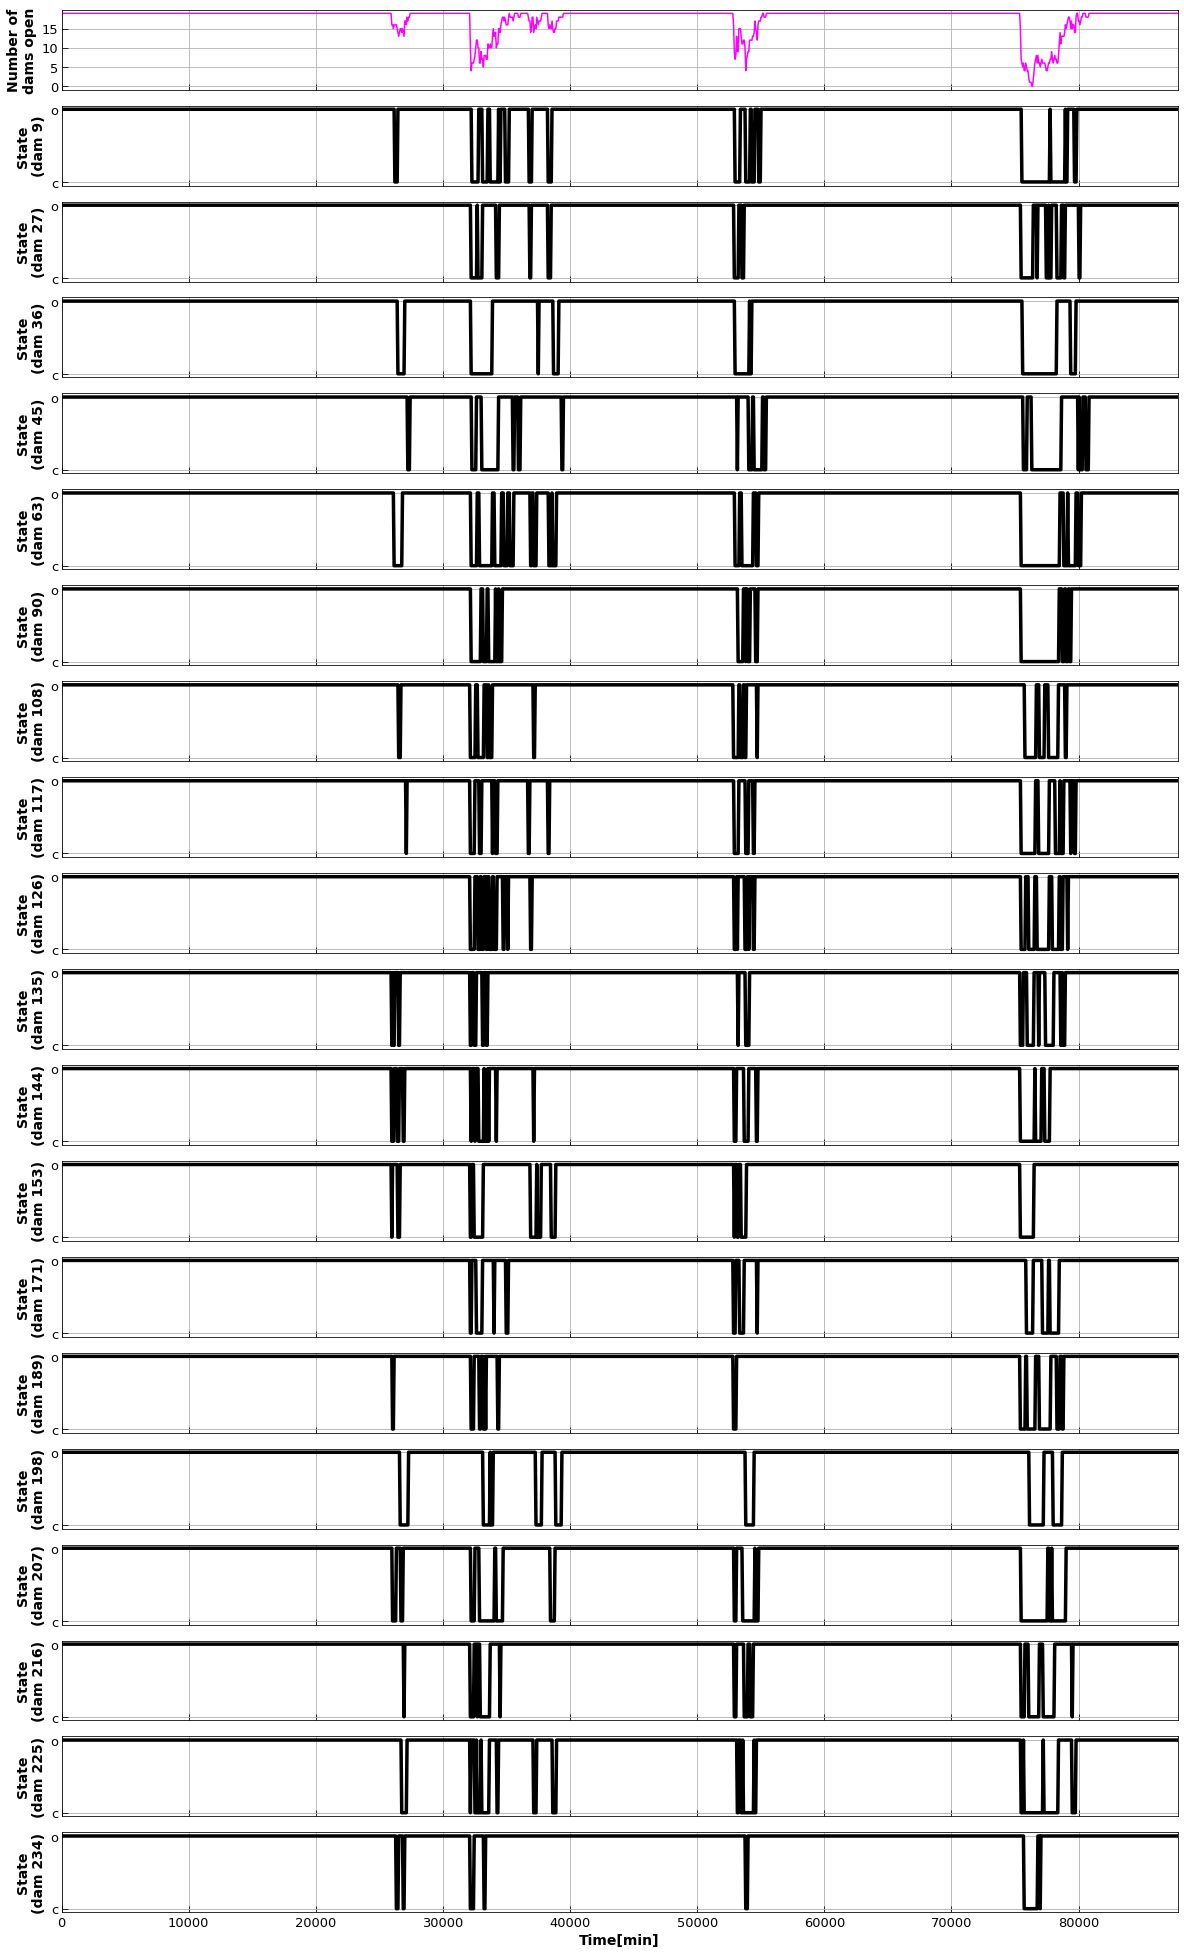

In [17]:
s_name = '_EF_M20_N10_U60'  #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
fig, ax = plt.subplots(1+len(dams), 1, figsize=(20,35), sharex=True)
ax[0].plot(tt, res, c='magenta', linewidth=1.5)
ax[0].set_ylabel('Number of\ndams open')
ax[0].set_yticks(np.arange(0, n_dams+1,5))
ax[0].set_xlim([0, max(tt)])
ax[0].grid()
j = 1
for dam in dams:
    idx = dams.index(dam)
    dam_state = [s[idx] for s in states]
    ax[j].plot(tt, dam_state, c= 'k')
    ax[j].set(ylabel=f'State\n(dam {dam})',yticklabels=['c', 'o'])
    ax[j].set_yticks([0,1])
    ax[j].grid()
    j +=1
ax[-1].set_xlabel('Time[min]')
# fig.savefig('../../Supp_DamStudy/nobug/States'+s_name + '.png',bbox_inches = 'tight', pad_inches = 0.5)

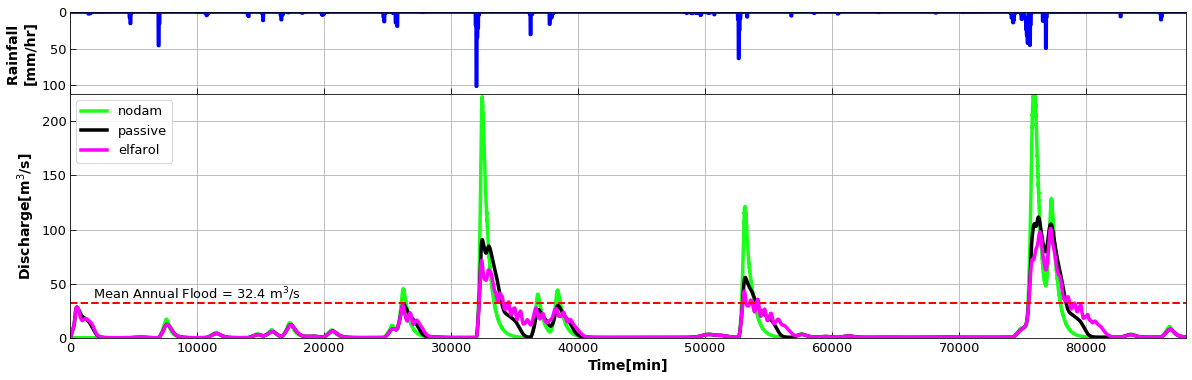

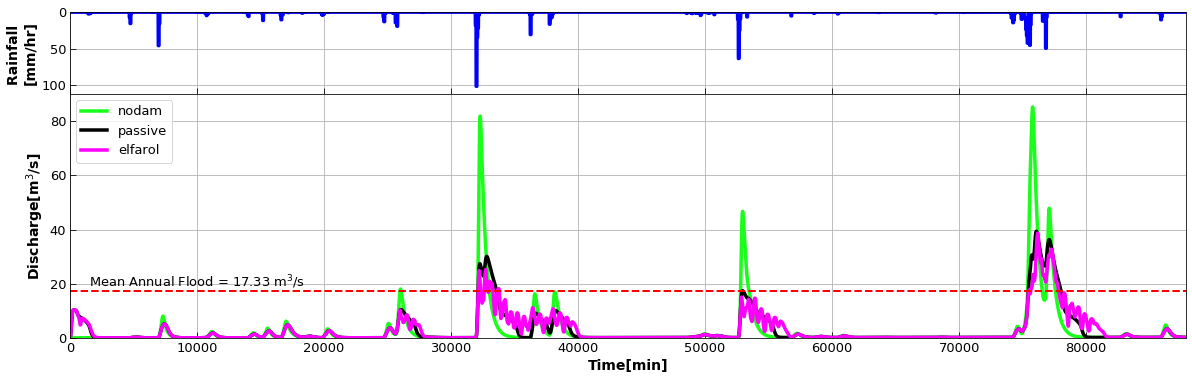

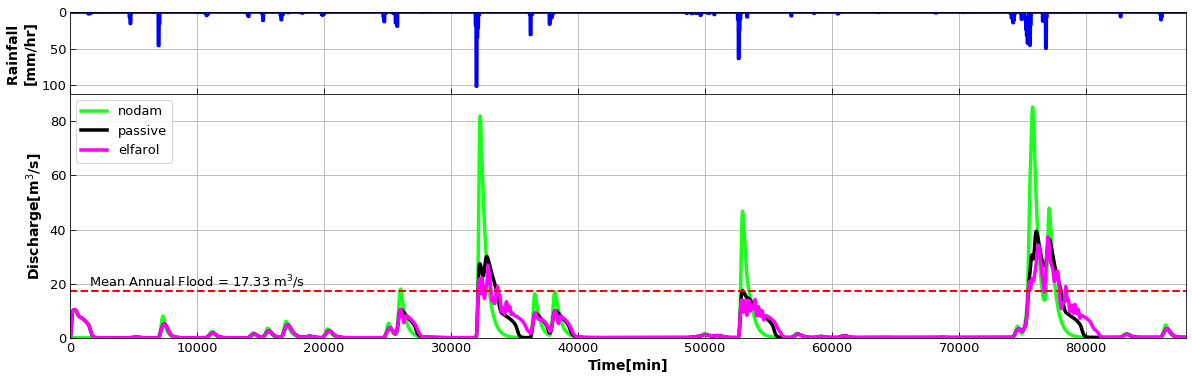

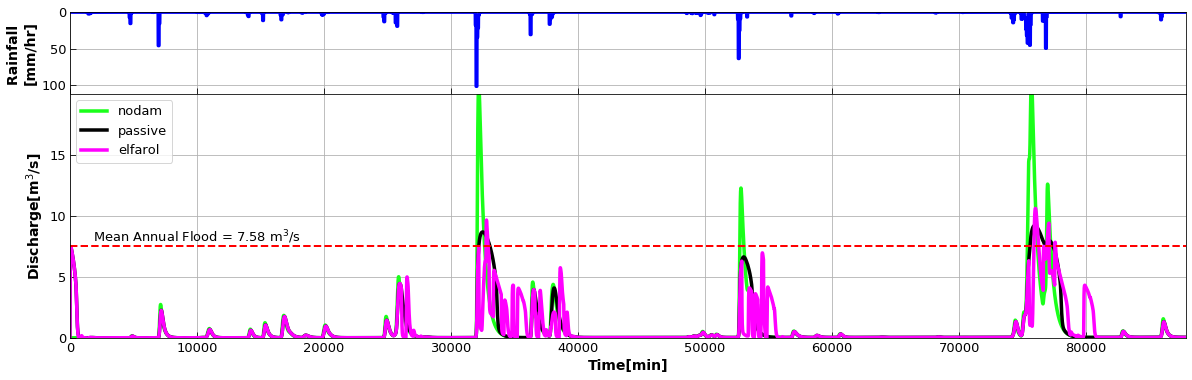

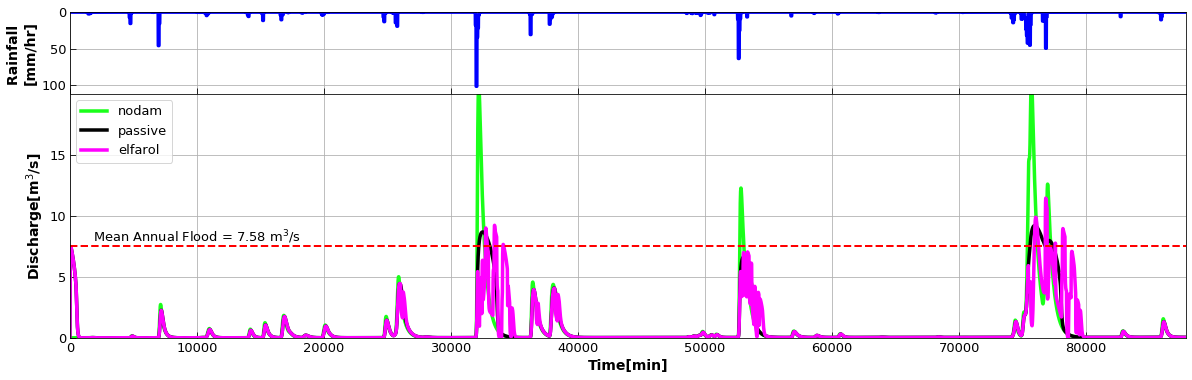

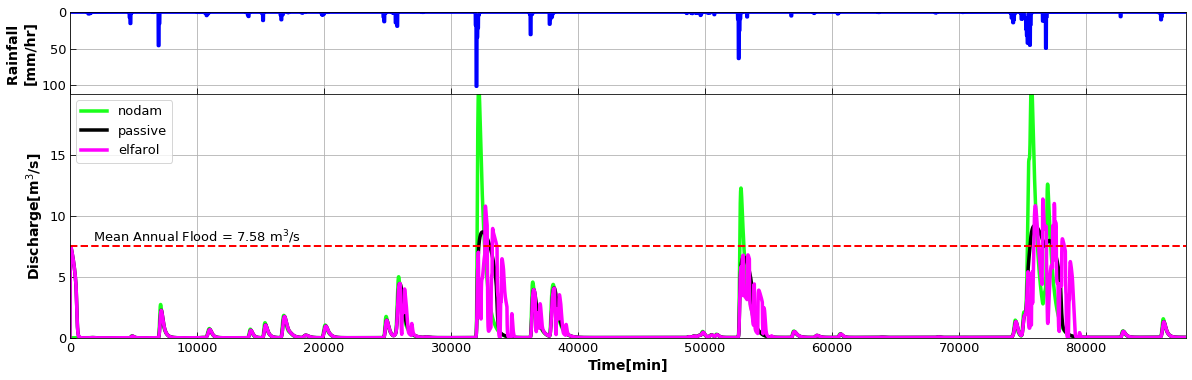

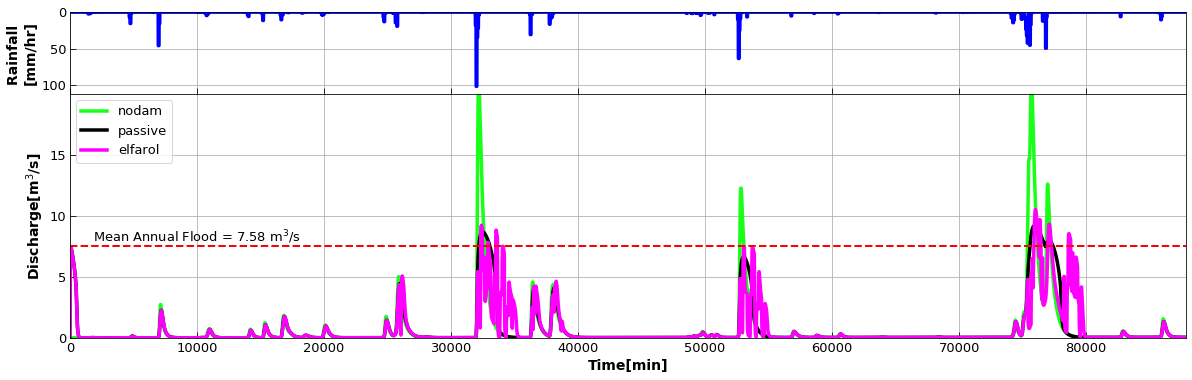

In [35]:
# s_name = '_EF_M20_N10_U60' 
pltkwargs = np.array([{'label':'nodam', 'color':'#1AFF1A'}, {'label':'passive', 'color':'#000000',},{'label':'elfarol', 'color':'magenta', 'alpha':1.0}])
pltKwargs = pltkwargs[[0,1,2]]
dataset = [dc_nodam,dc_passive, dc_elfarol]
plot_sim(0, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,225,50], area=60.7)#, save='../../Supp_DamStudy/nobug/Hydro0'+s_name)
plot_sim(81, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,90,20], area=20.25)#, save='../../Supp_DamStudy/nobug/Hydro81'+s_name)
plot_sim(162, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,90,20], area=20.25)#, save='../../Supp_DamStudy/nobug/Hydro162'+s_name)
plot_sim(35, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,20,5], area=4.75)#,save='../../Supp_DamStudy/nobug/Hydro35'+s_name)
plot_sim(197, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,20,5], area=4.75)#, save='../../Supp_DamStudy/nobug/Hydro197'+s_name)
plot_sim(224, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,20,5], area=4.75)#, save='../../Supp_DamStudy/nobug/Hydro224'+s_name)
plot_sim(143, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,20,5], area=4.75)#, save='../../Supp_DamStudy/nobug/Hydro143'+s_name)



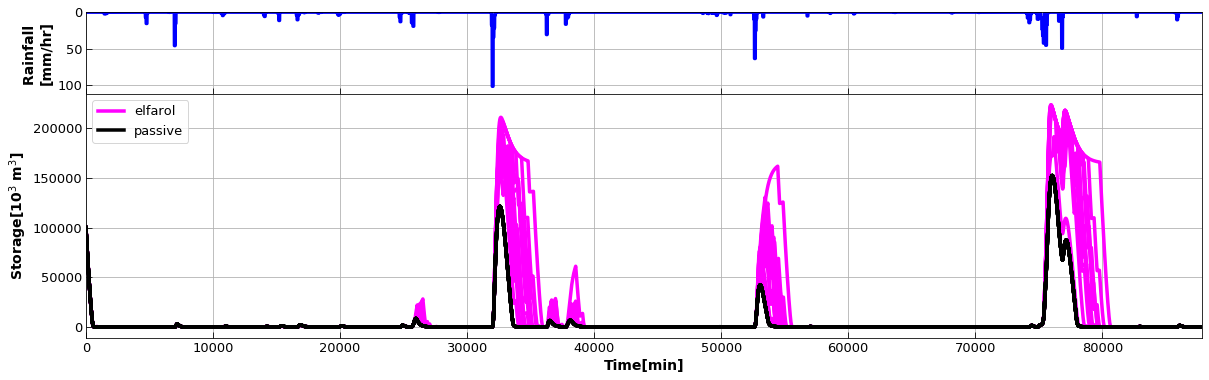

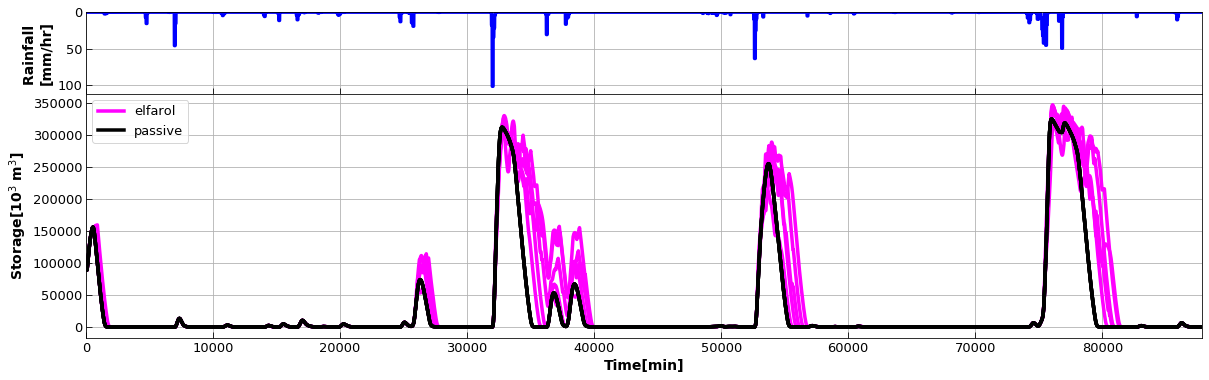

In [36]:
order_3 = [9,36,45,63,90,117,126,144,153,171,198,207,225,234] 
order_4 = [27, 189, 216, 135, 108]
pltKwargs = pltkwargs[[2,1]]
dataset = [st_elfarol, st_passive]
plot_sim(order_3, forcing, dataset, pltKwargs, d_type='storage')#, save='../../Supp_DamStudy/Order3_'+s_name)
plot_sim(order_4, forcing, dataset, pltKwargs, d_type='storage')#,save='../../Supp_DamStudy/Order4_'+s_name)

In [118]:
fstart = 15*2*memory_size
tt2 = np.arange(fstart, te, update)
len(dam9)

5815

In [119]:
dc_elfarol[dc_elfarol.index>fstart+update]['0']

620       9.659207
625       9.965444
630       9.965444
635      10.282297
640      10.608424
           ...    
87800     3.367525
87805     3.328650
87810     3.328650
87815     3.290176
87820     3.252108
Name: 0, Length: 17441, dtype: float64

In [142]:
from imp import reload 
import hlm_basic
reload(hlm_basic.tools)
from hlm_basic.tools import plot_sim